In [39]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for different plot
from sklearn.preprocessing import OneHotEncoder #for data preprocessing
from sklearn.preprocessing import StandardScaler #for scaling data
from sklearn.model_selection import train_test_split
#for data preprocessing using keras
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# keras classes required for building deep CNN model
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout 
from keras.utils import plot_model
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
import gc

In [40]:
#include both image path and labels into dataframe
df = pd.DataFrame({'Image':images,'Label':labels})
df.tail()
# df.info()

,Image,Label
19995,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist
19996,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist
19997,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist
19998,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist
19999,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,03_fist


In [41]:
images=[]
labels=[]

# loop over top 10 folders
for directory in os.listdir('/kaggle/input/leapgestrecog/leapGestRecog/'):
    for subdir in os.listdir(os.path.join('/kaggle/input/leapgestrecog/leapGestRecog/',directory)):
#         if directory=='01':
#             labels.append(subdir)
        for image in os.listdir(os.path.join('/kaggle/input/leapgestrecog/leapGestRecog/',directory, subdir)):
            img_path = os.path.join('/kaggle/input/leapgestrecog/leapGestRecog/', directory, subdir, image)
            images.append(img_path)
            labels.append(subdir)


In [42]:
unique_labels = np.unique(df['Label'])
label_to_integer = dict(zip(unique_labels, range(len(unique_labels))))

df['LabelInt'] = df['Label'].map(label_to_integer)

In [43]:
df['Label'] = df['LabelInt']

In [44]:
df = df.drop(columns=["LabelInt"])
df

,Image,Label
0,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,1
1,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,1
2,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,1
3,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,1
4,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,1
...,...,...
19995,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,2
19996,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,2
19997,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,2
19998,/kaggle/input/leapgestrecog/leapGestRecog/01/0...,2


In [45]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)

In [46]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
class CNNDataset(Dataset):
    """
    Custom dataset definition
    """
    def __init__(self, df, mode='train', transform=None):
        """
        """
        self.df = df
        self.mode= mode
        self.transform = transform
        
            
    def __getitem__(self, index):
        """
        """
        img_name = self.df.iloc[index]["Image"]
        image = Image.open(img_name)
                
        if self.mode == 'train':
            image = image.convert("RGB")
                
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels =  np.asarray(self.df.iloc[index]["Label"])
            return image, labels
            
        elif self.mode == 'val':
            image = image.convert("RGB")
            
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = np.asarray(self.df.iloc[index]["Label"])
            return image, labels
        
    def __len__(self):
        return len(self.df)

In [47]:
def get_dataloaders(input_size, batch_size, augment=False, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ])
    }
    
    df_dict={'train': train_df,
             'val':test_df
    }
    
    data_subsets = {x: CNNDataset(df_dict[x], 
                                  mode = x,
                                  transform=data_transforms[x]) for x in data_transforms.keys()}
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: DataLoader(data_subsets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

In [48]:
import torch
import torchvision.models as models

# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False


In [50]:
# Modify the last layer of the model
num_classes = 10 # replace with the number of classes in your dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


In [51]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


In [52]:
dataloaders = get_dataloaders(input_size=256, batch_size=64, shuffle=True)


In [53]:
train_loader = dataloaders['train']
val_loader = dataloaders['val']

In [54]:
#shifting model to gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [55]:
num_classes = 10

#Different model parameters to play around with
num_epochs = 4
learning_rate = 0.01

In [56]:
import torch.nn as nn


In [57]:
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_step = len(train_loader)
    
    #take out the following code if just starting to train
    #checkpoint = torch.load('PREVIOUS MODEL PATH')  for ex: torch.load('../input/trained-model/model_21.pth')
    #model.load_state_dict(checkpoint['state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    #epoch_before = checkpoint['epoch']
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(train_loader), 1):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            outputs = torch.squeeze(outputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        #'epoch' = epoch if just starting to train
        #'epoch' = epoch+epoch_before+1 afterwards
        model_file = { 'epoch': epoch,
                      'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}

        torch.save(model_file, "model" + str(epoch) + '.pth')  
        #str(epoch) if just starting to train 
        #str(epoch+epoch_before+1) afterwards

        model.eval()

        train_correct = 0
        train_total = 0
        with torch.no_grad():
            for data in tqdm(train_loader):
                images, labels = data
                
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                train_total += labels.size(0)

                train_correct += (predicted == labels).sum().item()
        print(train_correct, train_total)        
        #str(epoch) if just starting to train
        #str(epoch+epoch_before+1) afterwards
        print("epoch: " + str(epoch))
        print('Top One Error of the network on train images: %d %%' % (
                100 * (1 - train_correct / train_total)))


        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data in tqdm(val_loader):
                images, labels = data

                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                val_total += labels.size(0)

                val_correct += (predicted == labels).sum().item()
        print(val_correct, val_total)
        #str(epoch) if just starting to train
        #str(epoch+epoch_before+1) afterwards
        print("epoch: " + str(epoch))
        print('Top One Error of the network on validation images: %d %%' % (
                100 * (1 - val_correct / val_total)))
        

        gc.collect()

In [58]:
from tqdm import tqdm


In [59]:
train()

  0%|          | 0/250 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 250/250 [00:50<00:00,  5.86it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 250/250 [00:49<00:00,  5.05it/s]


15913 16000
epoch: 0
Top One Error of the network on train images: 0 %


100%|██████████| 63/63 [00:13<00:00,  4.82it/s]


3973 4000
epoch: 0
Top One Error of the network on validation images: 0 %


100%|██████████| 250/250 [00:50<00:00,  4.99it/s]


15983 16000
epoch: 1
Top One Error of the network on train images: 0 %


100%|██████████| 63/63 [00:12<00:00,  4.97it/s]


3989 4000
epoch: 1
Top One Error of the network on validation images: 0 %


100%|██████████| 250/250 [00:50<00:00,  4.99it/s]


15968 16000
epoch: 2
Top One Error of the network on train images: 0 %


100%|██████████| 63/63 [00:13<00:00,  4.83it/s]


3986 4000
epoch: 2
Top One Error of the network on validation images: 0 %


100%|██████████| 250/250 [00:50<00:00,  4.96it/s]


15994 16000
epoch: 3
Top One Error of the network on train images: 0 %


100%|██████████| 63/63 [00:12<00:00,  4.95it/s]


3994 4000
epoch: 3
Top One Error of the network on validation images: 0 %


  0%|          | 0/63 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 63/63 [00:12<00:00,  6.52it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 63/63 [00:12<00:00,  4.93it/s]


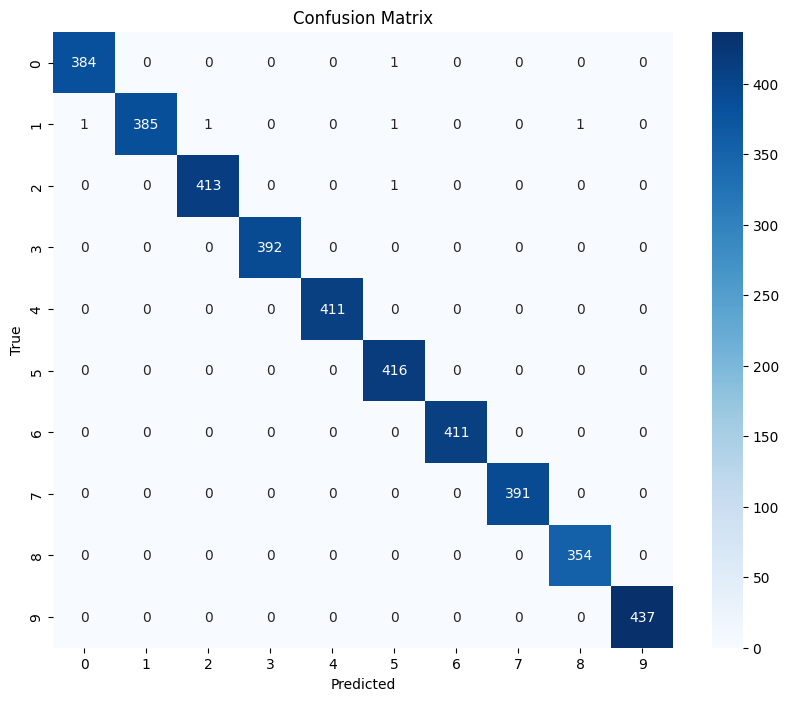

Confusion Matrix:
[[384   0   0   0   0   1   0   0   0   0]
 [  1 385   1   0   0   1   0   0   1   0]
 [  0   0 413   0   0   1   0   0   0   0]
 [  0   0   0 392   0   0   0   0   0   0]
 [  0   0   0   0 411   0   0   0   0   0]
 [  0   0   0   0   0 416   0   0   0   0]
 [  0   0   0   0   0   0 411   0   0   0]
 [  0   0   0   0   0   0   0 391   0   0]
 [  0   0   0   0   0   0   0   0 354   0]
 [  0   0   0   0   0   0   0   0   0 437]]


In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def validate_and_get_confusion_matrix():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot it actually
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)

# Call this function after your training loop
validate_and_get_confusion_matrix()

In [61]:
#from sklearn.metrics import precision_score
#p=precision_score(y_train, y_pred, average='weighted')
#print("Precision Score - ",p)

  0%|          | 0/63 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 63/63 [00:12<00:00,  6.83it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 63/63 [00:12<00:00,  4.98it/s]


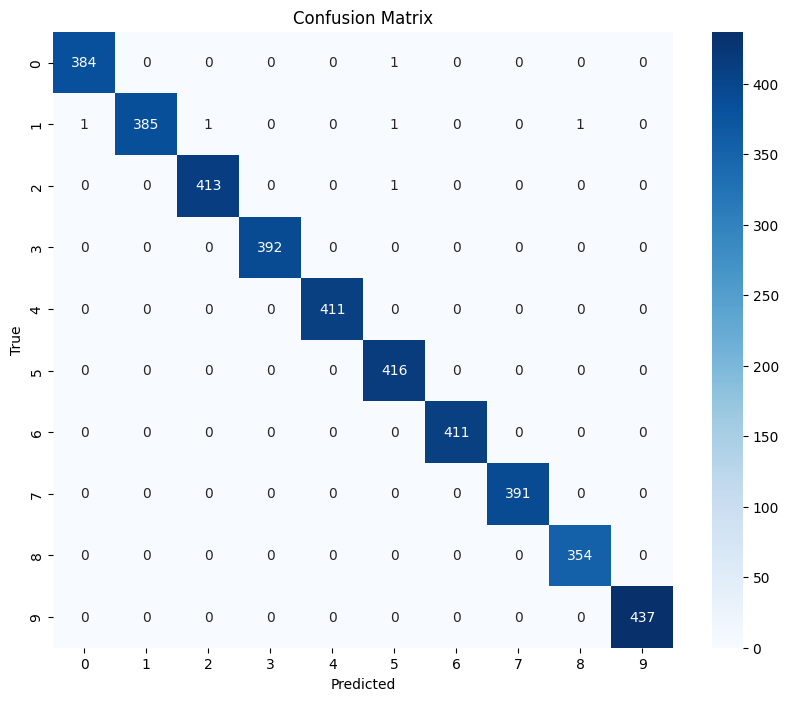

Confusion Matrix:
[[384   0   0   0   0   1   0   0   0   0]
 [  1 385   1   0   0   1   0   0   1   0]
 [  0   0 413   0   0   1   0   0   0   0]
 [  0   0   0 392   0   0   0   0   0   0]
 [  0   0   0   0 411   0   0   0   0   0]
 [  0   0   0   0   0 416   0   0   0   0]
 [  0   0   0   0   0   0 411   0   0   0]
 [  0   0   0   0   0   0   0 391   0   0]
 [  0   0   0   0   0   0   0   0 354   0]
 [  0   0   0   0   0   0   0   0   0 437]]
F1 Score: 0.9985
Recall: 0.9985
Precision: 0.9985

Per-class metrics:
Class 0:
  F1 Score: 0.9974
  Recall: 0.9974
  Precision: 0.9974
Class 1:
  F1 Score: 0.9948
  Recall: 0.9897
  Precision: 1.0000
Class 2:
  F1 Score: 0.9976
  Recall: 0.9976
  Precision: 0.9976
Class 3:
  F1 Score: 1.0000
  Recall: 1.0000
  Precision: 1.0000
Class 4:
  F1 Score: 1.0000
  Recall: 1.0000
  Precision: 1.0000
Class 5:
  F1 Score: 0.9964
  Recall: 1.0000
  Precision: 0.9928
Class 6:
  F1 Score: 1.0000
  Recall: 1.0000
  Precision: 1.0000
Class 7:
  F1 Score: 1.000

In [74]:
from sklearn.metrics import f1_score, recall_score, precision_score

def calculate_metrics(all_labels, all_preds):
    # Calculate metrics
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')

    # Print metrics
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    # You can also calculate these metrics for each class
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)

    # Print per-class metrics
    print("\nPer-class metrics:")
    for i in range(len(f1_per_class)):
        print(f"Class {i}:")
        print(f"  F1 Score: {f1_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")
        print(f"  Precision: {precision_per_class[i]:.4f}")

# Modify your validate_and_get_confusion_matrix function
def validate_and_get_confusion_matrix():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate and print metrics
    calculate_metrics(all_labels, all_preds)

# Call this function after your training loop
validate_and_get_confusion_matrix()